**Table of contents**<a id='toc0_'></a>    
- 1. [Problem 1: Optimal taxation with government consumption](#toc1_)    
- 2. [Problem 2: Labor adjustment costs](#toc2_)    
- 3. [Problem 3: Global optimizer with refined multi-start](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
# import
import numpy as np
from scipy import optimize
from scipy.optimize import minimize_scalar
import sympy as sm
from sympy import simplify
from sympy.solvers import solve
from sympy import *
sm.init_printing()
import matplotlib.pyplot as plt
from IPython.display import display, Math, Markdown
from types import SimpleNamespace

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

## 1. <a id='toc1_'></a>[Problem 1: Optimal taxation with government consumption](#toc0_)


Consider a worker choosing hours of labor, $L\in[0,24]$, to maximize utility: 

$$
\begin{align*}
V(w,\tau,G)&=\max_{L\in[0,24]}\ln\left(C^{\alpha}G^{1-\alpha}\right)-\nu\frac{L^{2}}{2}\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}
$$

where 

* $C$ is *private* consumption with weight $\alpha\in(0,1)$.
* $\kappa > 0$ is the *free private* consumption component.
* $C = (1-\tau)wL$ is the *costly private* consumption component.
* $w > 0 $ is the real wage.
* $\tau \in (0,1)$ is the labor-income tax rate.
* $G > 0 $ is *government* consumption with weight $1-\alpha$.
* $\nu > 0$ is the disutility of labor scaling factor


The baseline parameters are:

$$
\begin{align*}
\alpha &= 0.5\\
\kappa &= 1.0\\
\nu &= \frac{1}{2\cdot16^2} \\
w &= 1.0 \\ 
\tau &= 0.30 \\
\end{align*}
$$

In [59]:
# defining all variables in sympy
C = sm.symbols('C')
G = sm.symbols('G')
alpha = sm.symbols('alpha')
nu = sm.symbols('nu')
L = sm.symbols('L')
kappa = sm.symbols('kappa')
tau = sm.symbols('tau')
w = sm.symbols('w')
wtilde = sm.symbols('wtilde')
sigma = sm.symbols('sigma')
rho = sm.symbols('rho')
epsilon = sm.symbols('epsilon')

**Question 1:** Verify that the optimal labor supply choice is $L^{\star}(\tilde{w}) =\frac{-\kappa+\sqrt{\kappa^{2}+4\frac{\alpha}{\nu}\tilde{w}^2}}{2\tilde{w}}$, where $\tilde{w} = (1-\tau)w$, for $G\in\left\{1.0 , 2.0\right\}$.

In [ ]:
# define objective function
objective = sm.ln(C**alpha*G**(1-alpha))-nu*(L**2/2)
objective

In [ ]:
# substitute constraint into objective function
objective_subs = objective.subs(C, kappa+(1-tau)*w*L)
objective_subs

In [ ]:
# compute foc
foc = sm.diff(objective_subs, L)
# substitute wtilde into expression
foc_subs = foc.subs((1-tau)*w, wtilde)
foc_subs

In [ ]:
# solve foc
sol = sm.solve(sm.Eq(foc_subs,0),L)
sol

When multiplying through by $\frac{1}{\nu}$ in sol[1], we will get the expression $L^{\star}(\tilde{w}) =\frac{-\kappa+\sqrt{\kappa^{2}+4\frac{\alpha}{\nu}\tilde{w}^2}}{2\tilde{w}}$.
We have tried to use the sympy simplify, but cannot obtain the exact expression as provided in the question. Instead we vell evaluate the two expressions at the provided baseline parameters and show that they give the same answer.

In [42]:
# define baseline parameters
alpha = 0.5
kappa = 1.0
nu = 1/(2*16**2)
w = 1.0
tau = 0.3

In [43]:
# define sympy solution
def L_star_sol(kappa, alpha, nu, tau, w):
    return (-kappa*nu+sqrt(nu*(kappa**2*nu+4*(alpha)*((1-tau)*w)**2)))/(2*nu*(1-tau)*w)

# define optimal labor supply function provided in assignment
def L_star(kappa, alpha, nu, tau, w):
    return (-kappa+sqrt(kappa**2+4*(alpha/nu)*((1-tau)*w)**2))/(2*(1-tau)*w)

print(f'L_star_sol = {L_star_sol(kappa, alpha, nu, tau, w):.4f} and L_star = {L_star(kappa, alpha, nu, tau, w):.4f}')


L_star_sol = 15.3017 and L_star = 15.3017


We see that the two results are identical why we find it reasonable to verify that the optimal labor supply choice is as stated in the description.

**Question 2:** Illustrate how $L^{\star}(\tilde{w})$ depends on $w$.

In [44]:
# define vector of different values of w
w_vec = np.linspace(0.1,10,100)
# create vector of function values to plot
L_plot = np.zeros(len(w_vec))
# loop over different values of w
for i, wage in enumerate(w_vec):
    L_plot[i] = L_star(kappa, alpha, nu, tau, wage)

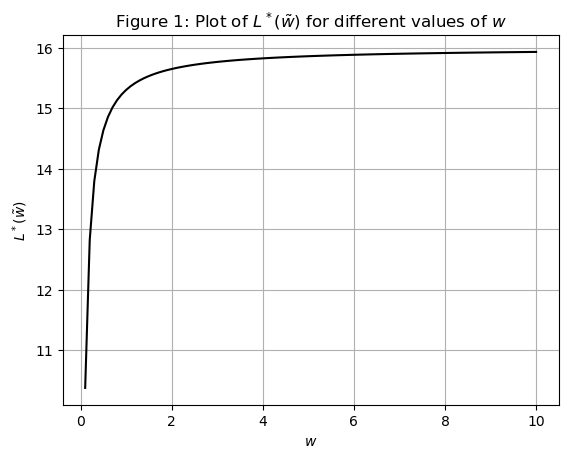

In [45]:
# create figure
fig = plt.figure()
# create plot
ax = fig.add_subplot(1, 1, 1)
ax.plot(w_vec, L_plot, color='black')
# alterations to figure
ax.grid()
ax.set_xlabel("$w$")
ax.set_ylabel(r'$L^*(\tilde{w})$')
ax.set_title(r'Figure 1: Plot of $L^*(\tilde{w})$ for different values of $w$')
plt.show()

For values of w > 0 in the interval $w \in [0.1 , 10] $, we see that the optimal labor supply converges towards $\sim$ 16 hours.


We now consider a government, who chooses $\tau$ and spend all of the taxes on government consumption so:

$$
G = \tau w L^{\star}((1-\tau)w)
$$

**Question 3:** Plot the implied $L$, $G$ and worker utility for a grid of $\tau$-values.


Note: We were a bit confused about the notation, but we find it reasonable to assume that the government tax revenue is equal to the tax rate * wage * hours worked (implying that $L^*((1-\tau)w)$ means that L is a function of $(1-\tau)w = \tilde{w}$) and not tax rate * wage * L * (1-tau)*w.

In [46]:
# define vector of different values of tau
tau_vec = np.linspace(0.1,0.9,54)

# create vector of function values to plot
L_impl = np.zeros(len(tau_vec))
# loop over different values of tau
for i, t in enumerate(tau_vec):
    L_impl[i] = L_star(kappa, alpha, nu, t, w)

# define G as a function of tau, w and L_star
G_func = lambda tau, w, L: tau*w*L
# create vector of function values to plot
G_impl = np.zeros(len(tau_vec))
# loop over different values of tau
for i, t in enumerate(tau_vec):
    G_impl[i] = G_func(t, w, L_impl[i])

# define consumption function
C_func = lambda kappa, tau, w, L: kappa+(1-tau)*w*L
# define worker utility
V_func = lambda C, G, alpha, nu, L: np.log(C**alpha*G**(1-alpha))-nu*(L**2/2)
# create vector of function values to plot
V_impl = np.zeros(len(tau_vec))
# loop over different values of tau
for i, t in enumerate(tau_vec):
    V_impl[i] = V_func(C_func(kappa, t, w, L_impl[i]), G_impl[i], alpha, nu, L_impl[i])


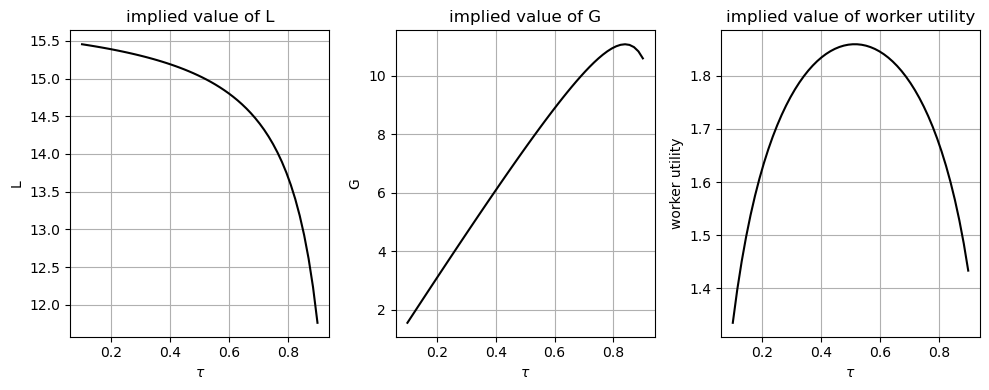

In [47]:
# create figure
fig = plt.figure(figsize=(10, 4))

# create plots
ax1 = fig.add_subplot(1, 3, 1)
ax1.plot(tau_vec, L_impl, color='black')
ax1.set_ylabel('L')
ax1.set_xlabel(r'$\tau$')
ax1.grid()
ax1.set_title('implied value of L')

ax2 = fig.add_subplot(1, 3, 2)
ax2.plot(tau_vec, G_impl, color='black')
ax2.set_ylabel('G')
ax2.set_xlabel(r'$\tau$')
ax2.grid()
ax2.set_title('implied value of G')

ax3 = fig.add_subplot(1, 3, 3)
ax3.plot(tau_vec, V_impl, color='black')
ax3.set_ylabel('worker utility')
ax3.set_xlabel(r'$\tau$')
ax3.grid()
ax3.set_title('implied value of worker utility')

plt.tight_layout()

**Question 4:** Find the socially optimal tax rate $\tau^{\star}\in(0,1)$ maximizing worker utility. Illustrate your result.

In order to solve the maximization problem, we insert the definitions of $C, G, L^*$ into the worker's utility maximization problem. We then solve for the optimal value of $\tau$.

In [48]:
# implementation of optimization in q1
import q1
# call function finding optimal tau
optimal_tau, max_utility = q1.optimal_tau()
print(f'Optimal tau = {optimal_tau:.4f}')
print(f'Max utility = {max_utility:.4f}')

Optimal tau = 0.5145
Max utility = 1.8592


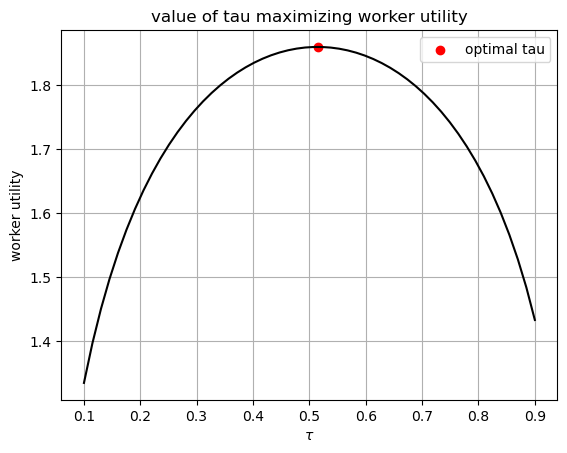

In [49]:
# create figure
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
# plot utility as function of tau
ax.plot(tau_vec, V_impl, color='black')
# plot optimal tau
plt.scatter(optimal_tau, max_utility, color='red', label='optimal tau')
# alterations to figure
ax.set_ylabel('worker utility')
ax.set_xlabel(r'$\tau$')
ax.grid()
ax.set_title('value of tau maximizing worker utility')
ax.legend()

A more general preference formulation for the worker is:

$$
\begin{align*}
\mathcal{V}(w,\tau,G)&=\max_{L\in[0,24]}\frac{\left[ \left( \alpha C^{\frac{\sigma-1}{\sigma}}+(1-\alpha) G^{\frac{\sigma-1}{\sigma}} \right)^{\frac{\sigma}{\sigma-1} }\right]^{1-\rho}-1}{1-\rho}- \nu\frac{L^{1+\varepsilon}}{1+\varepsilon},\,\,\,\varepsilon,\rho,\sigma>0,\,\,\,\rho,\sigma\neq1\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}    
$$

Optimal labor supply is now $L^{\star}(\tilde{w},G)$.

Questions 5 and 6 must be answered with the general formulation, and for 2 different set of parameters:

- Set 1:  $\sigma = 1.001$, $\rho = 1.001$ and $\varepsilon = 1.0$.
- Set 2:  $\sigma = 1.5$, $\rho = 1.5$ and $\varepsilon = 1.0 $.

**Question 5:** Find the $G$ that solves $G = \tau w L^{\star}((1-\tau)w,G)$ using the $\tau$ found in question 4.

*Hint: First write code that solves the worker problem for given values of $G$ and $\tau$. Then find the correct G based on this.*

In [88]:
sigma = 1.001
rho = 1.001
epsilon = 1.0

In [93]:
labor = q1.labor_supply(optimal_tau,w)
print(labor)

22.113006591796875


In [94]:
Gopt = q1.find_G(optimal_tau, w, labor)
print(G_opt)

6.8688764648437495


In [91]:
util = q1.CES_utility(optimal_tau, kappa, alpha, nu, w, sigma, rho, epsilon, labor)
print(util)

1.9666126685886471


In [92]:
CES_L = labor
#CES_Gopt = 6.8688764648437495

**Question 6:** Find the socially optimal tax rate, $\tau^{\star}$, maximizing worker utility, while keeping $G = \tau w L^{\star}((1-\tau)w,G)$.

In [95]:
# write your code here  
# call function finding optimal CES_tau
CES_optimal_tau, CES_max_utility = q1.CES_optimal_tau()
print(f'Optimal tau = {CES_optimal_tau:.4f}')
print(f'Max utility = {CES_max_utility:.4f}')

Optimal tau = 0.5226
Max utility = 1.9667


In [86]:
CES_tau_vec = np.linspace(0.1,0.9,54)

V_CES = np.zeros(len(CES_tau_vec))
# loop over different values of w
for i, CES_tau in enumerate(CES_tau_vec):
    V_CES[i] = (((alpha*(kappa+(1-CES_tau)*w*CES_L)**((sigma-1)/sigma)+(1-alpha)*(CES_tau*w*CES_L)**((sigma-1)/sigma))**(sigma/(sigma-1)))**(1-rho)-1)/(1-rho)-(nu*CES_L**(1+epsilon)/(1+epsilon))

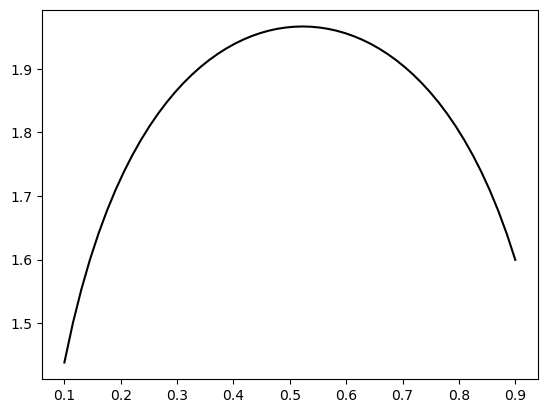

In [87]:
# create figure
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
# plot utility as function of tau
ax.plot(CES_tau_vec, V_CES, color='black')

## 2. <a id='toc2_'></a>[Problem 2: Labor adjustment costs](#toc0_)

You own a hair salon. You employ hairdressers, $\ell_t$, to produce haircuts, $y_t = \ell_t$.

The wage for each haridresser is $w$.

The demand for haircuts implies that the price of haircuts you can charge is $p_t = \kappa_t y_t^{-\eta}$, where $\kappa_t$ is a demand-shock and $\eta \in (0,1)$ measures the elasticity of demand.

Profits are:

$$
\Pi_t = p_t y_t - w \ell_t = \kappa_t \ell_t^{1-\eta} - w \ell_t
$$

Baseline parameters are:
- $\eta = 0.5$
- $w = 1.0$

**Question 1:** Verify numerically that $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ maximises profits, for $\kappa\in\left\{1.0 , 2.0\right\}$.

In [ ]:
# import profit maximization from q2
import q2
# numerical solution for kappa = 1.0
num1 = q2.max_profits(1.0, 0.5, 1.0)[0]
# numerical solution for kappa = 2.0
num2 = q2.max_profits(2.0, 0.5, 1.0)[0]
# analytical solution for kappa = 1.0
ana1 = ((1-0.5)*1.0/1.0)**(1/0.5)
# analytical solution for kappa = 2.0
ana2 = ((1-0.5)*2.0/1.0)**(1/0.5)

# check
print(f'num1 - ana1 = {num1-ana1:.5f} and num2 - ana2 = {num2-ana2:.5f}')

We now consider a *dynamic* version of the model.

* The demand-shock is a so-called AR(1) in logs, 

$$
\log \kappa_{t} = \rho \log \kappa_{t-1} + \epsilon_{t},\,\,\, \epsilon_{t+1} \sim \mathcal{N}(-0.5\sigma_{\epsilon}^2,\sigma_{\epsilon})
$$

* Any hiring or firing implies a fixed adjustment cost, $\iota > 0 $.
* Future profits are discounted with a monthly factor of $R \in (0,1)$.

The initial demand shock is $\kappa_{-1} = 1$ and the planning horizon is 10 years, i.e. 120 months so $t \in \{0,1,2,\dots,119\}$. Initially you don't have any employees, $\ell_{-1}=0$


The *ex post* value of the salon is *conditional* on the shock series is:

$$
h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119}) = \left[\sum_{t=0}^{119}R^{-t}\left[\kappa_{t}\ell_{t}^{1-\eta}-w\ell_{t}-\boldsymbol{1}_{\ell_{t}\neq\ell_{t-1}}\iota\right]\right]
$$

The *ex ante* expected value of the salon can be approximated by

$$
H = \mathbb{E}[h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119})] \approx \frac{1}{K}\sum_{k=0}^{K} h(\epsilon_0^k,\epsilon_1^k,\dots,\epsilon_{119}^k)
$$

where each $k\in\{0,1,\dots,K-1\}$ is a random shock series. Maximizing profitability means maximizing $H$.


Baseline parameters are: 

- $\rho = 0.90$
- $\iota = 0.01$
- $\sigma_{\epsilon} = 0.10$
- $R = \left(1+0.01\right)^{1/12}$

**Question 2:** Calculate $H$ if the policy  $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ from question 1 is followed. Choose $K$ so the approximation is good enough to not affect your results substantially.

We choose a $K=500$. For higher values of $K$ we get a very long run time, since the size of the grid increases drastically, we will comment further on our considartaions about the size of $K$ in the end of question 4. 

In [167]:
sn = SimpleNamespace()

# parameters
sn.rho = 0.90
sn.iota = 0.01
sn.sigma_e = 0.10
sn.R = (1+0.01)**(1/12)
sn.eta = 0.5
sn.w = 1.0
sn.T = 120 # number of months
sn.K = 500 # number of simulation draws for each month

# fix seed
np.random.seed(2023)
state = np.random.get_state()

In [168]:
# define data generating process
def DGP(sn):
    # set state
    np.random.set_state(state)
    # draw data points
    e = np.random.normal(loc=-0.5*sn.sigma_e**2, scale=sn.sigma_e, size=(sn.K, sn.T)) # draw T = 120 months K times
    return e

In [169]:
# create data
e_obs = DGP(sn)
# check dimensions of e_obs
print(shape(e_obs))

(500, 120)


e_obs has a shape of K rows and T = 120 columns.

In [170]:
# create vector of demand shocks in logs
log_kappa = np.zeros([sn.K,sn.T])
for k in range(0,sn.K):
    for t in range(0,sn.T):
        if t == 0:
            log_kappa_m1 = np.log(1)
        log_kappa[k,t] = sn.rho*log_kappa_m1+e_obs[k,t]
        log_kappa_m1 = log_kappa[k,t]

# create vector of demand shocks without logs
kappa = np.exp(log_kappa)

In [171]:
# compute number of employees from time t = 0 to t = 119
# insert number of employees in each period in a vector
def employees_vec():
    employees = np.zeros([sn.K,sn.T])
    for k in range(0,sn.K):
        for t in range(0,sn.T):
            # max profits for relevant value of kappa
            employees[k,t] = q2.max_profits(kappa[k,t],sn.eta, sn.w)
    return employees

In [172]:
# compute h for each k = {0,...,K-1}
employees = employees_vec()
h = np.zeros(sn.K)
for k in range(0,sn.K):
    for t in range(0,sn.T):
        if t == 0:
            # indicator function
            I = 1 if employees[k,t] != 0 else 0
        else:
            I = 1 if employees[k,t]!=employees[k,t-1] else 0
        # compute value for each period
        val = sn.R**(-t)*(kappa[k,t]*employees[k,t]**(1-sn.eta)-sn.w*employees[k,t]-I*sn.iota)
        # accumulate
        h[k] += val
        
# compute H
H = np.sum(h)/sn.K
print(f'H = {H:.3f}')

H = 27.797


The profits for this policy is then $H_{initial}=27.797$

Next, we consider policies on the form:

$$

\ell_{t}=\begin{cases}
\ell_t^{\ast}  & \text{if }\left|\ell_{t-1}-\ell_t^{\ast} \right|>\Delta\\
\ell_{t-1} & \text{else }
\end{cases}
\\
\text{where}\,\,\ell_t^{\ast} = \left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}} \\

$$
With $\Delta \geq 0$ and $\Delta = 0$ being the previous policy.



**Question 3:** Calculate $H$ if the policy above was followed with $\Delta = 0.05$. Does it improve profitability?

In [173]:
employees_new = employees_vec()
sn.Delta = 0.05
for k in range(0,sn.K):
    for t in range(0,sn.T):
        if t == 0:
            if abs(0-employees_new[k,t]) > sn.Delta:
                employees_new[k,t] = employees_new[k,t]
            else:
                employees_new[k,t] = 0
        else:
            if abs(employees_new[k,t-1]-employees_new[k,t]) > sn.Delta:
                employees_new[k,t] = employees_new[k,t]
            else:
                employees_new[k,t] = employees_new[k,t-1]

In [174]:
# compute h for each k = {0,...,K-1}
h_new = np.zeros(sn.K)
for k in range(0,sn.K):
    for t in range(0,sn.T):
        if t == 0:
            # indicator function
            I_new = 1 if employees_new[k,t] != 0 else 0
        else:
            I_new = 1 if employees_new[k,t]!=employees_new[k,t-1] else 0
        # compute value for each period
        val_new = sn.R**(-t)*(kappa[k,t]*employees_new[k,t]**(1-sn.eta)-sn.w*employees_new[k,t]-I_new*sn.iota)
        # accumulate
        h_new[k] += val_new

# compute H_new
H_new = np.sum(h_new)/sn.K
print(f'H_new = {H_new:.3f}')

H_new = 28.475


We see that the policy of introducing $\Delta$ increases profitability as $H_{\Delta=0.05}=28.475>27.797=H_{initial}$

**Question 4:** Find the optimal $\Delta$ maximizing $H$. Illustrate your result.

In [175]:
employees_opt = employees_vec()

# Define a list of potential Delta values to test
potential_delta = np.linspace(0, 0.1, 100)  # Adjust range and step size as needed

# Initialize variables to keep track of the best Delta and its corresponding H_new
best_delta = None
max_H_opt = -np.inf

H_val = []

# Iterate over potential deltas
for delta in potential_delta:

    # same code as before...
    for k in range(0,sn.K):
        for t in range(0,sn.T):
            if t == 0:
                if abs(0-employees_new[k,t]) > sn.Delta:
                    employees_new[k,t] = employees_new[k,t]
                else:
                    employees_new[k,t] = 0
            else:
                if abs(employees_opt[k,t-1]-employees_opt[k,t]) > delta:
                    employees_opt[k,t] = employees_opt[k,t]
                else:
                    employees_opt[k,t] = employees_opt[k,t-1]

    h_opt = np.zeros(sn.K)
    for k in range(0,sn.K):
        for t in range(0,sn.T):
            if t == 0:
                I_opt = 1 if employees_opt[k,t] != 0 else 0
            else:
                I_opt = 1 if employees_opt[k,t]!=employees_opt[k,t-1] else 0
            val_opt = sn.R**(-t)*(kappa[k,t]*employees_opt[k,t]**(1-sn.eta)-sn.w*employees_opt[k,t]-I_opt*sn.iota)
            h_opt[k] += val_opt

    H_opt = np.sum(h_opt)/sn.K
    
    H_val.append(H_opt)
    
    # Check if this is the best H_new so far
    if H_opt > max_H_opt:
        max_H_opt = H_opt
        best_delta = delta

print(f'Optimal Delta = {best_delta:.3f}')
print(f'maximum H_new = {max_H_opt:.3f}')


Optimal Delta = 0.054
maximum H_new = 28.464


When solving for the optimal $\Delta$ we see that for $T=120$ and $K=500$ we cannot optain a higher profits, even for a higher $\Delta$ below the figure, we explain that increasing $K=10.000$ we can see a increase in profits for the optimal value of $\Delta$

The results here is that the optimal $\Delta=0.054$ which yield the profits $H_{optimal\Delta=0.054}=28.464$. Which intuitivly does not make sence, since the optimal value of $\Delta$ should yield the highest profit observed.

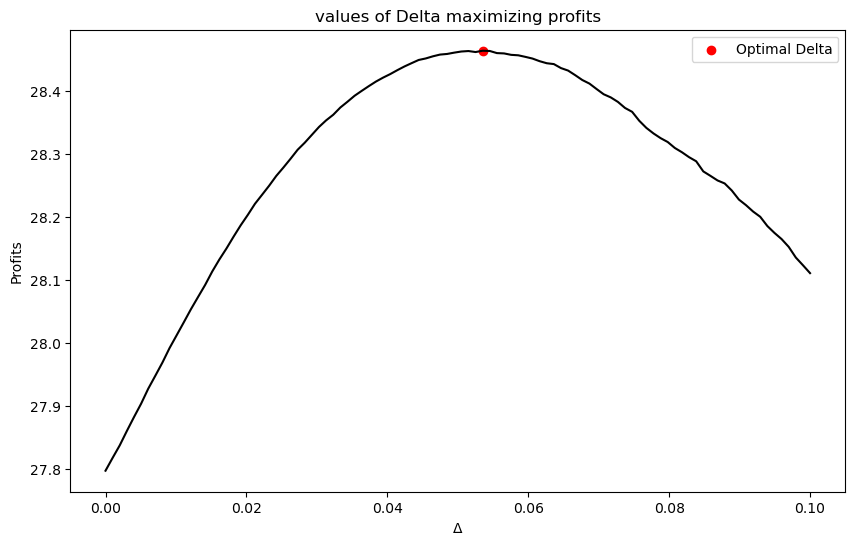

In [207]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1, 1, 1)
plt.plot(potential_delta, H_val, color='black')
plt.scatter(best_delta, max_H_opt, color='red', label='Optimal Delta')
# alterations to figure
ax.set_ylabel('Profits')
ax.set_xlabel(r'$\Delta$')
ax.set_title('values of Delta maximizing profits')
ax.legend()
plt.show()

We have solved the above code in two ways, since we are not please with the accuracy with the size of K we can use when T=120. For relativly small increases in K we get a very significant longer run time, since the size of the grid we loop through increases drastically.

Therefore we have also solves the code for T=10 (Time in years instead of months) and K=10.000 here we optain more smooth results and the graph is not bumpy. With these parameter values we get an initial profit of $H_{initial}=2.563$ and including the delta we optain a profit of $H_{\Delta=0.05}=2.517$ why we conclude that the introduction of $\Delta$ increases profits. When we solve for the optimal value of $\Delta$ we get that $\Delta=0.063$ with the profit $H_{optimal\Delta=0.063}=2.519$. We can based on this conclude that the profits can be increased slightly by changing $\Delta$ to a more optimal value. The accumulated profits will of cource increase for a higher T, but the conclusion regarding how presice we can determed the *ex anta* value depends only on K. 


**Question 5:** Suggest an alternative policy you believe might improve profitability. Implement and test your policy.



In [177]:
# write your code here

## 3. <a id='toc3_'></a>[Problem 3: Global optimizer with refined multi-start](#toc0_)

We consider the Griewank function:

$$ f(\boldsymbol{x}) = \sum^n_{i=1} \frac{x^2_i}{4000}-\prod^n_{i=1}\cos\left(\frac{x_i}{\sqrt{i}}\right)+1$$

The **global minimum** of this function is $f(0,0) = 0$ (remember: $\cos(0)=1$).<br>
But the function also have a lot of **local minima**.

In [178]:
def griewank(x):
    return griewank_(x[0],x[1])
    
def griewank_(x1,x2):
    A = x1**2/4000 + x2**2/4000
    B = np.cos(x1/np.sqrt(1))*np.cos(x2/np.sqrt(2))
    return A-B+1

A **refined global optimizer with multi-start** is:

1. Choose *bounds* for $\mathbf{x}$ and *tolerance* $\tau > 0$.
2. Choose number of *warm-up iterations*, $\underline{K} > 0$ and *maximum number of iterations*, $K > \underline{K}$.
3. In each iteration for $k \in \{0,1,\dots,K-1\}$:

    A. Draw random $\mathbf{x}^k$ uniformly within chosen bounds.

    B. If $k < \underline{K}$ go to step E.

    C. Calculate $\chi^k = 0.50\cdot\frac{2}{1+\exp((k-\underline{K})/100)}$  

    D. Set $\mathbf{x}^{k0} = \chi^k \mathbf{x}^k + (1-\chi^k)\mathbf{x}^{\ast} $

    E. Run optimizer with $\mathbf{x}^{k0}$ as initial guess and $\mathbf{x}^{k\ast}$ as result.

    F. Set $\mathbf{x}^{\ast} = \mathbf{x}^{k\ast}$ if $k = 0$ or $f(\mathbf{x}^{k\ast}) < f(\mathbf{x}^{\ast})$

    G. If $f(\mathbf{x}^{\ast}) < \tau$ go to step 4.

4. Return the result $\mathbf{x}^{\ast}$.

As settings we choose:

* $x_1,x_2 \in  [-600,600]$
* $\tau = 10^{-8}$
* $\underline{K}=10$
* $K=1000$

The optimizer in Step 3.E is `BFGS` with a tolerance of $\tau$.

**Question 1:** Implement the refined global optimizer with multi-start. Illustrate how the effective initial guesses $\mathbf{x}^{k0}$ vary with the iteration counter $k$.

In [179]:
# write your code here
def global_optimizer(x1, x2, tol=1e-8, warm_up_iterations, max_iter=1000):
    for k in range(0,max_iter):
        x1, x2 = np.random.uniform(x1, x2)
        x1, x2 = x
        

SyntaxError: non-default argument follows default argument (255512415.py, line 2)

**Question 2:** Is it a better idea to set $\underline{K} = 100$? Is the convergence faster?

In [ ]:
# write your code here